In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    device = torch.device("cpu")
    print("CPU")

np.random.seed(1234)

CUDA


In [3]:
# Define the neural network
class PINN(nn.Module):
    def __init__(self, hidden_layers=3, neurons=20):
        super(PINN, self).__init__()
        layers = [nn.Linear(1, neurons), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(neurons, 1))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [25]:
# Define parameters
E = 1.0  # Young's modulus (arbitrary units)
I = 5.0  # Moment of inertia (arbitrary units)
P = -1.0  # Load at free end
L = 2.0  # Beam length

In [26]:
# Generate training data (collocation points)
x_train = torch.linspace(0, L, 100, requires_grad=True).view(-1, 1)

# Initialize model, optimizer, and loss function
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [27]:
# Physics-Informed Loss Function
def loss_function(x):
    y = model(x)  # Predicted displacement
    dy_dx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x, torch.ones_like(dy_dx), create_graph=True)[0]
    
    physics_loss = torch.mean((E * I * d2y_dx2 - P * (L - x)) ** 2)
    
    # Boundary conditions
    bc_loss = torch.mean((model(torch.tensor([[0.0]])) - 0) ** 2)  # y(0) = 0
    bc_loss += torch.mean((dy_dx[0] - 0) ** 2)  # y'(0) = 0
    
    return physics_loss + bc_loss

In [28]:
# Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_function(x_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')

# Test the trained model
x_test = torch.linspace(0, L, 100).view(-1, 1)
y_pred = model(x_test).detach().numpy()

Epoch 0: Loss = 1.1023448705673218
Epoch 500: Loss = 1.5670620996388607e-05
Epoch 1000: Loss = 3.1511492579738842e-06
Epoch 1500: Loss = 1.4745169210073072e-06
Epoch 2000: Loss = 1.0213874475084594e-06
Epoch 2500: Loss = 0.003373953280970454
Epoch 3000: Loss = 8.516744856024161e-07
Epoch 3500: Loss = 4.8155772674363106e-05
Epoch 4000: Loss = 0.00043152121361345053
Epoch 4500: Loss = 0.0006758877425454557


In [29]:
def exact_solution(x, E, I, F, L):
    a = F/(6*E*I)
    b = (3*L*x**2 - x**3)
    return a*b

u_exact = exact_solution(x_test, E, I, P, L) 

L2 Error: 14.139962196350098


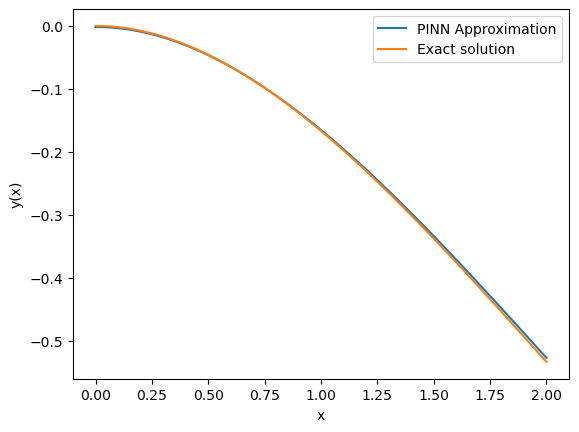

In [30]:
l2_error = np.linalg.norm(x_test - u_exact)
print(f"L2 Error: {l2_error}")

# Plot results
plt.plot(x_test, y_pred, label='PINN Approximation')
plt.plot(x_test, u_exact, label="Exact solution")
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.show()

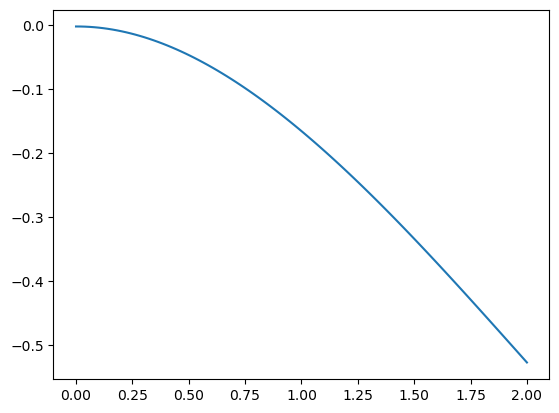

In [31]:
plt.figure()
plt.plot(x_test.numpy(), y_pred, label='PINN Approximation')
plt.show()